In [1]:
import pandas as pd
import glob
import codecs
import os
from tqdm import tqdm_notebook as tqdm

# preprocessing

In [2]:
dirlist = [
    "dokujo-tsushin",
    "it-life-hack",
    "kaden-channel",
    "livedoor-homme",
    "movie-enter",
    "peachy",
    "smax",
    "sports-watch",
    "topic-news"
    ]

In [3]:
df = pd.DataFrame(columns=[ "class", "news" ])
for i in tqdm(dirlist):
    path = "../data/livedoor-news-corpus/" + i + "/*.txt"
    files = glob.glob(path)
    files.pop()
    for j in tqdm(files):
        f = codecs.open(j, 'r', 'utf-8')
        data = f.read() 
        f.close()
        t = pd.Series([ i, "".join(data.split("\n")[3:]) ], index = df.columns)
        df  = df.append(t, ignore_index=True)

In [4]:
df

,class,news
0,dokujo-tsushin,ストレスの大半は人間関係といっても過言ではない。特に職場での人間関係は自分では選べないし、苦...
1,dokujo-tsushin,ショッピングモールの飲食店エリアで、今まで経験したことの無いような吐き気に襲われてトイレに駆...
2,dokujo-tsushin,メルセデス・ベンツ日本は、2月18日（金）、6年ぶりにフルモデルチェンジした「CLSクラス」...
3,dokujo-tsushin,フリーカメラマンの夏美さん(仮名・36歳)は、最近、仕事の現場でこんな経験をしたそうだ。「仕...
4,dokujo-tsushin,女性の人生において、仕事や恋愛と並んでプライオリティが高いもの。それは、美容ではないだろうか...
5,dokujo-tsushin,はじめまして、大堀恵です。今回から僭越ながら独女のみなさんのお悩みを聞かせていただくことにな...
6,dokujo-tsushin,自転車には興味はあれど、さてどうしようかとお悩みの独女の皆様。まったく興味はないけど、北条晶...
7,dokujo-tsushin,実在した武士の家計簿を元に制作された映画「武士の家計簿」。家計簿をつけ収入収支を管理し、誠実...
8,dokujo-tsushin,「今年の新人、使えないよね」「私もそう思ってた！」。新年度が始まって一段落つき、オフィスのあ...
9,dokujo-tsushin,9月に入り、雑誌をめくりながら秋冬のワードローブを考えるのも楽しくなる季節。今年はコートも新...


# 1) SCDV based word2vec

## create word2vec

In [5]:
import logging
import numpy as np
from gensim.models import Word2Vec
import pickle
import MeCab
import time
from sklearn.preprocessing import normalize
import sys
import re

In [6]:
start = time.time()
tokenizer =  MeCab.Tagger("-Owakati")  
sentences = []
print ("Parsing sentences from training set...")

# Loop over each news article.
for review in tqdm(df["news"]):
    try:
        # Split a review into parsed sentences.
        result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
        result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
        h = result.split(" ")
        h = list(filter(("").__ne__, h))
        sentences.append(h)
    except:
        continue

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 200     # Word vector dimensionality
min_word_count = 20   # Minimum word count
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

print ("Training Word2Vec model...")
# Train Word2Vec model.
model = Word2Vec(
    sentences,
    workers=num_workers,
    hs = 0,
    sg = 1,
    negative = 10,
    iter = 25,
    size=num_features,
    min_count = min_word_count,
    window = context,
    sample = downsampling,
    seed=1
    )

model_name = str(num_features) + "features_" + str(min_word_count) + "minwords_" + str(context) + "context_len2alldata"
model.init_sims(replace=True)
# Save Word2Vec model.
print ("Saving Word2Vec model...")
model.save("../data/livedoor-news-corpus/model/" + model_name)
endmodeltime = time.time()

print ("time : ", endmodeltime-start)

Parsing sentences from training set...


2019-08-18 09:44:16,288 : INFO : collecting all words and their counts
2019-08-18 09:44:16,289 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types



Training Word2Vec model...


2019-08-18 09:44:19,011 : INFO : collected 71628 word types from a corpus of 3907594 raw words and 7367 sentences
2019-08-18 09:44:19,013 : INFO : Loading a fresh vocabulary
2019-08-18 09:44:19,265 : INFO : effective_min_count=20 retains 11850 unique words (16% of original 71628, drops 59778)
2019-08-18 09:44:19,266 : INFO : effective_min_count=20 leaves 3682875 word corpus (94% of original 3907594, drops 224719)
2019-08-18 09:44:19,443 : INFO : deleting the raw counts dictionary of 71628 items
2019-08-18 09:44:19,448 : INFO : sample=0.001 downsamples 34 most-common words
2019-08-18 09:44:19,449 : INFO : downsampling leaves estimated 2653733 word corpus (72.1% of prior 3682875)
2019-08-18 09:44:19,546 : INFO : estimated required memory for 11850 words and 200 dimensions: 24885000 bytes
2019-08-18 09:44:19,547 : INFO : resetting layer weights
2019-08-18 09:44:31,388 : INFO : training model with 40 workers on 11850 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=10 win

Saving Word2Vec model...


2019-08-18 10:17:55,015 : INFO : saved ../data/livedoor-news-corpus/model/200features_20minwords_10context_len2alldata


time :  2036.49369597435


In [7]:
#model.wv.save_word2vec_format("/Users/01018534/Downloads/testw2v.txt", binary=False)

## plain word2vec t-SNE Visualization

In [8]:
word2vec_model=pickle.load(open("../data/livedoor-news-corpus/model/" + model_name, "rb"))
 
%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import numpy as np

skip=0
limit=241 

vocab = word2vec_model.wv.vocab
emb_tuple = tuple([ word2vec_model[v] for v in vocab ])
X = np.vstack(emb_tuple)
 
tsne_model = TSNE(n_components=2, random_state=0, verbose=2)
np.set_printoptions(suppress=True)
tsne_model.fit_transform(X) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11850 samples in 0.336s...
[t-SNE] Computed neighbors for 11850 samples in 257.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11850
[t-SNE] Computed conditional probabilities for sample 2000 / 11850
[t-SNE] Computed conditional probabilities for sample 3000 / 11850
[t-SNE] Computed conditional probabilities for sample 4000 / 11850
[t-SNE] Computed conditional probabilities for sample 5000 / 11850
[t-SNE] Computed conditional probabilities for sample 6000 / 11850
[t-SNE] Computed conditional probabilities for sample 7000 / 11850
[t-SNE] Computed conditional probabilities for sample 8000 / 11850
[t-SNE] Computed conditional probabilities for sample 9000 / 11850
[t-SNE] Computed conditional probabilities for sample 10000 / 11850
[t-SNE] Computed conditional probabilities for sample 11000 / 11850
[t-SNE] Computed conditional probabilities for sample 11850 / 11850
[t-SNE] Mean sigma: 0.272153
[t-SNE] Computed co

array([[ 38.207222  ,  43.088757  ],
       [ -9.679705  ,   0.14298686],
       [ -2.3452215 ,   1.0295364 ],
       ...,
       [-25.55234   ,  -5.6700635 ],
       [-41.38821   ,   1.0312077 ],
       [-49.841183  ,  37.830647  ]], dtype=float32)

In [9]:
pickle.dump(tsne_model, open("../data/livedoor-news-corpus/model/tsne_plain.pkl", "wb"))

## create gwbowv

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [11]:
def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step

def cluster_GMM(num_clusters, word_vectors):
    # Initalize a GMM object and use it for clustering.
    clf =  GaussianMixture(
        n_components=num_clusters,
        covariance_type="tied",
        init_params='kmeans',
        max_iter=50
        )
    # Get cluster assignments.
    clf.fit(word_vectors)
    idx = clf.predict(word_vectors)
    print ("Clustering Done...", time.time()-start, "seconds")
    # Get probabilities of cluster assignments.
    idx_proba = clf.predict_proba(word_vectors)
    # Dump cluster assignments and probability of cluster assignments. 
    pickle.dump(idx, open('../data/livedoor-news-corpus/model/gmm_latestclusmodel_len2alldata.pkl', "wb"))
    print ("Cluster Assignments Saved...")

    pickle.dump(idx_proba, open( '../data/livedoor-news-corpus/model/gmm_prob_latestclusmodel_len2alldata.pkl', "wb"))
    print ("Probabilities of Cluster Assignments Saved...")
    return (idx, idx_proba)

def read_GMM(idx_name, idx_proba_name):
    # Loads cluster assignments and probability of cluster assignments. 
    idx = pickle.load(open('../data/livedoor-news-corpus/model/gmm_latestclusmodel_len2alldata.pkl', "rb"))
    idx_proba = pickle.load(open( '../data/livedoor-news-corpus/model/gmm_prob_latestclusmodel_len2alldata.pkl', "rb"))
    print ("Cluster Model Loaded...")
    return (idx, idx_proba)

def get_probability_word_vectors(featurenames, model, word_centroid_map, num_clusters, word_idf_dict):
    # This function computes probability word-cluster vectors
    prob_wordvecs = {}
    for word in word_centroid_map:
        prob_wordvecs[word] = np.zeros( num_clusters * num_features, dtype="float32" )
        for index in range(0, num_clusters):
            try:
                prob_wordvecs[word][index*num_features:(index+1)*num_features] = model[word] * word_centroid_prob_map[word][index] * word_idf_dict[word]
            except:
                continue

    # prob_wordvecs_idf_len2alldata = {}
    # i = 0
    # for word in featurenames:
    #     i += 1
    #     if word in word_centroid_map:    
    #         prob_wordvecs_idf_len2alldata[word] = {}
    #         for index in range(0, num_clusters):
    #                 prob_wordvecs_idf_len2alldata[word][index] = model[word] * word_centroid_prob_map[word][index] * word_idf_dict[word] 

    

    # for word in prob_wordvecs_idf_len2alldata.keys():
    #     prob_wordvecs[word] = prob_wordvecs_idf_len2alldata[word][0]
    #     for index in prob_wordvecs_idf_len2alldata[word].keys():
    #         if index==0:
    #             continue
    #         prob_wordvecs[word] = np.concatenate((prob_wordvecs[word], prob_wordvecs_idf_len2alldata[word][index]))
    return prob_wordvecs

def create_cluster_vector_and_gwbowv(prob_wordvecs, wordlist, word_centroid_map, word_centroid_prob_map, dimension, word_idf_dict, featurenames, num_centroids, train=False):
    # This function computes SDV feature vectors.
    bag_of_centroids = np.zeros( num_centroids * dimension, dtype="float32" )
    global min_no
    global max_no

    for word in wordlist:
        try:
            temp = word_centroid_map[word]
        except:
            continue

        bag_of_centroids += prob_wordvecs[word]

    norm = np.sqrt(np.einsum('...i,...i', bag_of_centroids, bag_of_centroids))
    if(norm!=0):
        bag_of_centroids /= norm

    # To make feature vector sparse, make note of minimum and maximum values.
    if train:
        min_no += min(bag_of_centroids)
        max_no += max(bag_of_centroids)

    return bag_of_centroids

In [12]:
num_features = 200     # Word vector dimensionality
min_word_count = 20   # Minimum word count
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

model_name = str(num_features) + "features_" + str(min_word_count) + "minwords_" + str(context) + "context_len2alldata"
# Load the trained Word2Vec model.
model = Word2Vec.load("../data/livedoor-news-corpus/model/" + model_name)
# Get wordvectors for all words in vocabulary.
word_vectors = model.wv.syn0

# Load train data.
train, test = train_test_split(df, test_size=0.3, random_state=40)
all = df

# Set number of clusters.
#num_clusters = 40
num_clusters = 20
# Uncomment below line for creating new clusters.
idx, idx_proba = cluster_GMM(num_clusters, word_vectors)

# Uncomment below lines for loading saved cluster assignments and probabaility of cluster assignments.
# idx_name = "gmm_latestclusmodel_len2alldata.pkl"
# idx_proba_name = "gmm_prob_latestclusmodel_len2alldata.pkl"
# idx, idx_proba = read_GMM(idx_name, idx_proba_name)

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number
word_centroid_map = dict(zip( model.wv.index2word, idx ))
# Create a Word / Probability of cluster assignment dictionary, mapping each vocabulary word to
# list of probabilities of cluster assignments.
word_centroid_prob_map = dict(zip( model.wv.index2word, idx_proba ))

2019-08-18 10:27:27,781 : INFO : loading Word2Vec object from ../data/livedoor-news-corpus/model/200features_20minwords_10context_len2alldata
2019-08-18 10:27:28,049 : INFO : loading wv recursively from ../data/livedoor-news-corpus/model/200features_20minwords_10context_len2alldata.wv.* with mmap=None
2019-08-18 10:27:28,051 : INFO : setting ignored attribute vectors_norm to None
2019-08-18 10:27:28,053 : INFO : loading vocabulary recursively from ../data/livedoor-news-corpus/model/200features_20minwords_10context_len2alldata.vocabulary.* with mmap=None
2019-08-18 10:27:28,054 : INFO : loading trainables recursively from ../data/livedoor-news-corpus/model/200features_20minwords_10context_len2alldata.trainables.* with mmap=None
2019-08-18 10:27:28,056 : INFO : setting ignored attribute cum_table to None
2019-08-18 10:27:28,058 : INFO : loaded ../data/livedoor-news-corpus/model/200features_20minwords_10context_len2alldata
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: D

Clustering Done... 2653.946446418762 seconds
Cluster Assignments Saved...
Probabilities of Cluster Assignments Saved...


## color scatter map

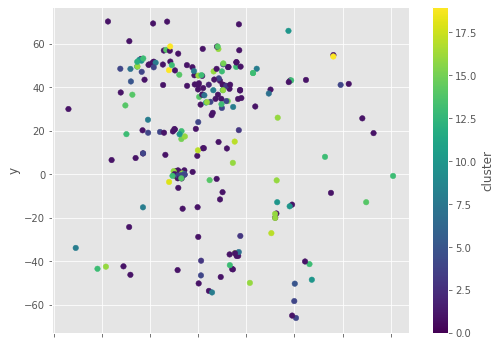

In [13]:
plt.style.use('ggplot') 
plainw2v = pd.DataFrame(tsne_model.embedding_[skip:limit, 0], columns = ["x"])
plainw2v["y"] = pd.DataFrame(tsne_model.embedding_[skip:limit, 1])
plainw2v["word"] = list(vocab)[skip:limit]
plainw2v["cluster"] = idx[skip:limit]
plainw2v.plot.scatter(x="x", y="y", c="cluster", cmap="viridis", figsize=(8, 6), s=30)

# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
# plotly.offline.init_notebook_mode(connected=False)
# # Create a trace
# trace = go.Scatter(
#     x =model.embedding_[skip:limit, 0],
#     y = model.embedding_[skip:limit, 1],
        
#     text=list(vocab.keys()),
#     mode = 'markers+text'
# )

# data = [trace]

# # Plot and embed in ipython notebook!
# plotly.offline.iplot(data)

## Computing tf-idf values.

In [14]:
traindata = []
for review in all["news"]:
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    traindata.append(" ".join(h))

tfv = TfidfVectorizer(dtype=np.float32)
tfidfmatrix_traindata = tfv.fit_transform(traindata)
featurenames = tfv.get_feature_names()
idf = tfv._tfidf.idf_

# Creating a dictionary with word mapped to its idf value 
print ("Creating word-idf dictionary for Training set...")

word_idf_dict = {}
for pair in zip(featurenames, idf):
    word_idf_dict[pair[0]] = pair[1]
    
# Pre-computing probability word-cluster vectors.
prob_wordvecs = get_probability_word_vectors(featurenames, model, word_centroid_map, num_clusters, word_idf_dict)

Creating word-idf dictionary for Training set...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## for gensim keyedvectors

In [15]:
#from gensim.models import KeyedVectors
#file = codecs.open('../data/livedoor-news-corpus/model/temp2.txt', 'w', 'utf-8')
#string_list = [str(len(prob_wordvecs)), str(len(list(prob_wordvecs.values())[0]))]
#string_list.append("\n")
#file.writelines(" ".join(string_list))
#for key, value in tqdm(prob_wordvecs.items()):
#    string_list = []
#    string_list.append(key)
#    for i in value:
#        string_list.append(str(i))
#    string_list.append("\n")
#    file.writelines(" ".join(string_list))
#file.close()

In [16]:
#word2vec_weighted = KeyedVectors.load_word2vec_format("../data/livedoor-news-corpus/model/temp2.txt", binary=False)
#word2vec_weighted.save("../data/livedoor-news-corpus/model/vector-response-test/word2vec_weighted.model")

In [17]:
pickle.dump(prob_wordvecs, open("../data/livedoor-news-corpus/model/prob_wordvecs.pkl", "wb"))

## gwbowv is a matrix which contains normalised document vectors.

In [18]:
gwbowv = np.zeros( (train["news"].size, num_clusters*(num_features)), dtype="float32" )

counter = 0

min_no = 0
max_no = 0
for review in train["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = h
    gwbowv[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters, train=True)
    counter+=1
    if counter % 1000 == 0:
        print ("Train News Covered : ", counter)

gwbowv_name = "SDV_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

gwbowv_test = np.zeros( (test["news"].size, num_clusters*(num_features)), dtype="float32" )

counter = 0

for review in test["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = h
    gwbowv_test[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters)
    counter+=1
    if counter % 1000 == 0:
        print ("Test News Covered : ", counter)

test_gwbowv_name = "TEST_SDV_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

Train News Covered :  1000
Train News Covered :  2000
Train News Covered :  3000
Train News Covered :  4000
Train News Covered :  5000
Test News Covered :  1000
Test News Covered :  2000


In [19]:
len(gwbowv[0])

4000

In [20]:
print ("Making sparse...")
# Set the threshold percentage for making it sparse. 
percentage = 0.04
min_no = min_no*1.0/len(train["news"])
max_no = max_no*1.0/len(train["news"])
print ("Average min: ", min_no)
print ("Average max: ", max_no)
thres = (abs(max_no) + abs(min_no))/2
thres = thres*percentage

# Make values of matrices which are less than threshold to zero.
temp = abs(gwbowv) < thres
gwbowv[temp] = 0

temp = abs(gwbowv_test) < thres
gwbowv_test[temp] = 0

#saving gwbowv train and test matrices
np.save("../data/livedoor-news-corpus/model/" + gwbowv_name, gwbowv)
np.save("../data/livedoor-news-corpus/model/" + test_gwbowv_name, gwbowv_test)

Making sparse...
Average min:  -0.14696163542950172
Average max:  0.1323355927115452


## plot modified word vector representation

In [21]:
skip=0
limit=241 

vocab = list(prob_wordvecs.keys())
tsne_target = []
for i in range(limit):
    tsne_target.append(prob_wordvecs[vocab[i]])
X = np.vstack(tsne_target)
 
tsne_model_scdv = TSNE(n_components=2, random_state=0, verbose=2)
np.set_printoptions(suppress=True)
tsne_model_scdv.fit_transform(X)
pickle.dump(tsne_model_scdv, open("../data/livedoor-news-corpus/model/tsne_scdv.pkl", "wb"))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 241 samples in 0.045s...
[t-SNE] Computed neighbors for 241 samples in 2.461s...
[t-SNE] Computed conditional probabilities for sample 241 / 241
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.124s
[t-SNE] Iteration 50: error = 66.5310822, gradient norm = 0.4375553 (50 iterations in 0.255s)
[t-SNE] Iteration 100: error = 63.2702942, gradient norm = 0.5046802 (50 iterations in 0.262s)
[t-SNE] Iteration 150: error = 62.9354668, gradient norm = 0.5353026 (50 iterations in 0.257s)
[t-SNE] Iteration 200: error = 67.3902283, gradient norm = 0.4810399 (50 iterations in 0.267s)
[t-SNE] Iteration 250: error = 65.6909409, gradient norm = 0.5171687 (50 iterations in 0.294s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.690941
[t-SNE] Iteration 300: error = 1.1289619, gradient norm = 0.0082608 (50 iterations in 0.288s)
[t-SNE] Iteration 350: error = 0.7137761, gradient norm = 0.0111723 (

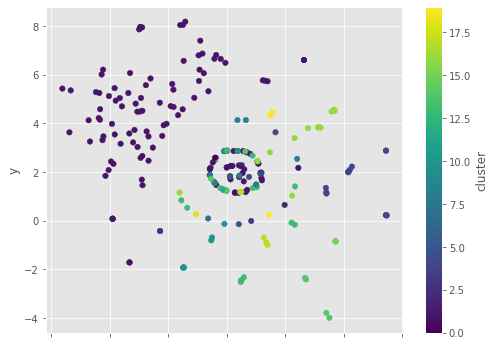

In [22]:
scdv_tsne = pd.DataFrame(tsne_model_scdv.embedding_[skip:limit, 0], columns = ["x"])
scdv_tsne["y"] = pd.DataFrame(tsne_model_scdv.embedding_[skip:limit, 1])
scdv_tsne["word"] = list(vocab)[skip:limit]
scdv_tsne["cluster"] = idx[skip:limit]
scdv_tsne.plot.scatter(x="x", y="y", c="cluster", cmap="viridis", figsize=(8, 6), s=30)

In [23]:
# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
# plotly.offline.init_notebook_mode(connected=False)
# # Create a trace
# trace = go.Scatter(
#     x =tsne_model_scdv.embedding_[skip:limit, 0],
#     y = tsne_model_scdv.embedding_[skip:limit, 1],
#     text=list(vocab)[skip:limit],
#     mode = 'markers+text'
# )

# data = [trace]

# # Plot and embed in ipython notebook!
# plotly.offline.iplot(data)

## test lgb SCDV based word2vec

In [24]:
from sklearn.metrics import classification_report
import lightgbm as lgb

start = time.time()
clf = lgb.LGBMClassifier(objective="multiclass")
clf.fit(gwbowv, train["class"])
Y_true, Y_pred  = test["class"], clf.predict(gwbowv_test)
print ("Report")
print (classification_report(Y_true, Y_pred, digits=6))
print ("Accuracy: ", clf.score(gwbowv_test, test["class"]))
print ("Time taken:", time.time() - start, "\n")

Report
                precision    recall  f1-score   support

dokujo-tsushin   0.820896  0.876494  0.847784       251
  it-life-hack   0.896414  0.907258  0.901804       248
 kaden-channel   0.909091  0.883534  0.896130       249
livedoor-homme   0.843478  0.664384  0.743295       146
   movie-enter   0.880702  0.958015  0.917733       262
        peachy   0.856574  0.846457  0.851485       254
          smax   0.980989  0.973585  0.977273       265
  sports-watch   0.926829  0.950000  0.938272       280
    topic-news   0.923695  0.898438  0.910891       256

      accuracy                       0.896427      2211
     macro avg   0.893185  0.884240  0.887185      2211
  weighted avg   0.896482  0.896427  0.895388      2211

Accuracy:  0.8964269561284487
Time taken: 616.8018832206726 



# 2) fasttext-average

In [25]:
res = []
for review in all["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = list(h)
    res.append(" ".join(words))
corpus = " ".join(res)
f = codecs.open('../data/livedoor-news-corpus/fasttext_corpus.txt', 'w', 'utf-8') # 書き込みモードで開く
f.write(corpus) # 引数の文字列をファイルに書き込む
f.close() # ファイルを閉じる

In [26]:
# from gensim.models.wrappers import FastText
# fasttext_model = FastText.load_fasttext_format('../data/livedoor-news-corpus/model/fasttext_model_200dim')

In [27]:
import fasttext
fasttext_model = fasttext.train_unsupervised(
    '../data/livedoor-news-corpus/fasttext_corpus.txt',
    model='skipgram',
    dim=200
    )
fasttext_model.save_model('../data/livedoor-news-corpus/model/fasttext_model_200dim.bin')

In [28]:
def plain_docvec(num_features, wordlist, model, train=False):
    # This function computes SDV feature vectors.
    bag_of_centroids = np.zeros( num_features, dtype="float32" )
    global min_no
    global max_no

    for word in wordlist:
        bag_of_centroids += model[word]

    norm = np.sqrt(np.einsum('...i,...i', bag_of_centroids, bag_of_centroids))
    if(norm!=0):
        bag_of_centroids /= norm

    # To make feature vector sparse, make note of minimum and maximum values.
    if train:
        min_no += min(bag_of_centroids)
        max_no += max(bag_of_centroids)

    return bag_of_centroids

## gwbowv is a matrix which contains normalised document vectors.

In [29]:
num_features = 200
plain_fasttext = np.zeros( (train["news"].size, num_features), dtype="float32" )

counter = 0

min_no = 0
max_no = 0
for review in tqdm(train["news"]):
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = list(h)
    plain_fasttext[counter] = plain_docvec(num_features, words, fasttext_model, train=True)
    counter+=1

plain_fasttext_test = np.zeros( (test["news"].size, num_features), dtype="float32" )

counter = 0

for review in tqdm(test["news"]):
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = list(h)
    plain_fasttext_test[counter] = plain_docvec(num_features, words, fasttext_model, train=False)
    counter+=1

## test lgb fasttext-average

In [30]:
from sklearn.metrics import classification_report
import lightgbm as lgb

start = time.time()
clf = lgb.LGBMClassifier(objective="multiclass")
clf.fit(plain_fasttext, train["class"])
Y_true, Y_pred  = test["class"], clf.predict(plain_fasttext_test)
print ("Report")
print (classification_report(Y_true, Y_pred, digits=6))
print ("Accuracy: ", clf.score(plain_fasttext_test, test["class"]))
print ("Time taken:", time.time() - start, "\n")

Report
                precision    recall  f1-score   support

dokujo-tsushin   0.876000  0.872510  0.874251       251
  it-life-hack   0.908333  0.879032  0.893443       248
 kaden-channel   0.896825  0.907631  0.902196       249
livedoor-homme   0.760870  0.719178  0.739437       146
   movie-enter   0.902174  0.950382  0.925651       262
        peachy   0.839844  0.846457  0.843137       254
          smax   0.954887  0.958491  0.956685       265
  sports-watch   0.920415  0.950000  0.934974       280
    topic-news   0.922131  0.878906  0.900000       256

      accuracy                       0.894166      2211
     macro avg   0.886831  0.884732  0.885530      2211
  weighted avg   0.893739  0.894166  0.893716      2211

Accuracy:  0.8941655359565808
Time taken: 41.777841329574585 



# 3) SCDV based fasttext

In [31]:
from gensim.models.wrappers.fasttext import FastText
fasttext_model_200 = FastText.load_fasttext_format('../data/livedoor-news-corpus/model/fasttext_model_200dim')

2019-08-18 11:00:33,012 : WARNING : Slow version of gensim.models.deprecated.word2vec is being used
2019-08-18 11:00:33,017 : INFO : loading 27530 words for fastText model from ../data/livedoor-news-corpus/model/fasttext_model_200dim.bin
2019-08-18 11:00:46,369 : INFO : loading weights for 27530 words for fastText model from ../data/livedoor-news-corpus/model/fasttext_model_200dim.bin
2019-08-18 11:00:49,759 : INFO : loaded (27530, 200) weight matrix for fastText model from ../data/livedoor-news-corpus/model/fasttext_model_200dim.bin


In [32]:
# Get wordvectors for all words in vocabulary.
word_vectors = fasttext_model_200.wv.syn0

# Set number of clusters.
#num_clusters = 60
num_clusters = 20
# Uncomment below line for creating new clusters.
idx, idx_proba = cluster_GMM(num_clusters, word_vectors)

# Uncomment below lines for loading saved cluster assignments and probabaility of cluster assignments.
# idx_name = "gmm_latestclusmodel_len2alldata.pkl"
# idx_proba_name = "gmm_prob_latestclusmodel_len2alldata.pkl"
# idx, idx_proba = read_GMM(idx_name, idx_proba_name)

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number
word_centroid_map = dict(zip( fasttext_model_200.wv.index2word, idx ))
# Create a Word / Probability of cluster assignment dictionary, mapping each vocabulary word to
# list of probabilities of cluster assignments.
word_centroid_prob_map = dict(zip( fasttext_model_200.wv.index2word, idx_proba ))

Clustering Done... 240.06751775741577 seconds
Cluster Assignments Saved...
Probabilities of Cluster Assignments Saved...


In [33]:
num_features = 200

## Pre-computing probability word-cluster vectors.

In [34]:
prob_wordvecs = get_probability_word_vectors(featurenames, fasttext_model_200, word_centroid_map, num_clusters, word_idf_dict)

## for gensim keyedvectors

In [35]:
#file = codecs.open('../data/livedoor-news-corpus/model/temp3.txt', 'w', 'utf-8')
#string_list = [str(len(prob_wordvecs)), str(len(list(prob_wordvecs.values())[0]))]
#string_list.append("\n")
#file.writelines(" ".join(string_list))
#for key, value in tqdm(prob_wordvecs.items()):
#    string_list = []
#    string_list.append(key)
#    for i in value:
#        string_list.append(str(i))
#    string_list.append("\n")
#    file.writelines(" ".join(string_list))
#file.close()

In [36]:
#fasttext_weighted = KeyedVectors.load_word2vec_format("../data/livedoor-news-corpus/model/temp3.txt", binary=False)
#fasttext_weighted.save("../data/livedoor-news-corpus/model/vector-response-test/fasttext_weighted.model")

In [37]:
pickle.dump(prob_wordvecs, open("../data/livedoor-news-corpus/model/prob_wordvecs_fasttext.pkl", "wb"))

## gwbowv is a matrix which contains normalised document vectors.

In [38]:
gwbowv_fasttext = np.zeros( (train["news"].size, num_clusters*(num_features)), dtype="float32" )

counter = 0

min_no = 0
max_no = 0
for review in train["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = list(h)
    gwbowv_fasttext[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters, train=True)
    counter+=1
    if counter % 1000 == 0:
        print ("Train News Covered : ", counter)

gwbowv_name = "SDV_fasttext_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

gwbowv_fasttext_test = np.zeros( (test["news"].size, num_clusters*(num_features)), dtype="float32" )

counter = 0

for review in test["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000", "").replace("\n", "")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = list(h)
    gwbowv_fasttext_test[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters)
    counter+=1
    if counter % 1000 == 0:
        print ("Test News Covered : ", counter)

test_gwbowv_name = "TEST_SDV_fasttext_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

Train News Covered :  1000
Train News Covered :  2000
Train News Covered :  3000
Train News Covered :  4000
Train News Covered :  5000
Test News Covered :  1000
Test News Covered :  2000


In [39]:
gwbowv_fasttext[0]

array([ 0.00028236,  0.00030988, -0.00050646, ..., -0.        ,
        0.        ,  0.        ], dtype=float32)

In [40]:
print ("Making sparse...")
# Set the threshold percentage for making it sparse. 
percentage = 0.04
min_no = min_no*1.0/len(train["news"])
max_no = max_no*1.0/len(train["news"])
print ("Average min: ", min_no)
print ("Average max: ", max_no)
thres = (abs(max_no) + abs(min_no))/2
thres = thres*percentage

# Make values of matrices which are less than threshold to zero.
temp = abs(gwbowv_fasttext) < thres
gwbowv_fasttext[temp] = 0

temp = abs(gwbowv_fasttext_test) < thres
gwbowv_fasttext_test[temp] = 0

#saving gwbowv train and test matrices
np.save("../data/livedoor-news-corpus/model/" + gwbowv_name, gwbowv_fasttext)
np.save("../data/livedoor-news-corpus/model/" + test_gwbowv_name, gwbowv_fasttext_test)

Making sparse...
Average min:  -0.14099508699656826
Average max:  0.15489805220713718


## test lgb SCDV based fasttext

In [41]:
from sklearn.metrics import classification_report
import lightgbm as lgb

start = time.time()
clf = lgb.LGBMClassifier(objective="multiclass")
clf.fit(gwbowv_fasttext, train["class"])
Y_true, Y_pred  = test["class"], clf.predict(gwbowv_fasttext_test)
print ("Report")
print (classification_report(Y_true, Y_pred, digits=6))
print ("Accuracy: ", clf.score(gwbowv_fasttext_test, test["class"]))
print ("Time taken:", time.time() - start, "\n")

Report
                precision    recall  f1-score   support

dokujo-tsushin   0.854331  0.864542  0.859406       251
  it-life-hack   0.881890  0.903226  0.892430       248
 kaden-channel   0.897959  0.883534  0.890688       249
livedoor-homme   0.852174  0.671233  0.750958       146
   movie-enter   0.884892  0.938931  0.911111       262
        peachy   0.804598  0.826772  0.815534       254
          smax   0.959559  0.984906  0.972067       265
  sports-watch   0.906897  0.939286  0.922807       280
    topic-news   0.888430  0.839844  0.863454       256

      accuracy                       0.883763      2211
     macro avg   0.881192  0.872475  0.875384      2211
  weighted avg   0.883318  0.883763  0.882560      2211

Accuracy:  0.8837630031659882
Time taken: 225.42754912376404 

